# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger
from src.sim.strategies import STRATEGIES
from src.sim.scenario import clear_controller, reset_controller_price

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
market_names = ["wsteth"]  # , "sfrxeth", "weth", "wbtc"]
config = "high_volatility"
scenario_ = Scenario(config, market_names)
print(
    f"Running {scenario_.num_steps} steps with frequency {scenario_.pricepaths.config['freq']}."
)

[INFO][17:13:13][src.sim.scenario]-23016: Fetching wsteth market from subgraph
[WARNING][17:13:16][crvusdsim.pool_data.metadata.market]-23016: User 0x76f7af8bea6462b17367eabd3fef08238d815f84 has shares in band 222 but band is empty. Skipping user...
[INFO][17:13:16][src.sim.scenario]-23016: Market snapshot as 2024-01-15 16:40:23
[INFO][17:13:16][src.sim.scenario]-23016: Bands snapshot as 2024-01-14 19:02:47
[INFO][17:13:16][src.sim.scenario]-23016: Users snapshot as 2024-01-15 15:04:35
[INFO][17:13:25][src.sim.scenario]-23016: Using 245600 1Inch quotes from 2023-11-19 19:00:00 to 2023-12-19 19:00:00
[INFO][17:13:25][src.utils.poolgraph]-23016: Found 20 valid trading cycles of length 3.


Running 288 steps with frequency 5min.


In [5]:
scenario = deepcopy(scenario_)
strategy = STRATEGIES[config](DEFAULT_METRICS)
strategy.apply_shocks(scenario)
scenario.prepare_for_run()

In [6]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2024-01-15 22:13:16'),
 'Bad Debt on Controller Wsteth': 0.0,
 'Bad Debt': 0.0,
 'System Health on Controller Wsteth': 1.0712174946313624,
 'System Health': 1.0712174946313624,
 'Borrower Loss': 0.0,
 'Hard Liquidation Losses': 0.0,
 'Soft Liquidation Losses': 0.0,
 'Keeper Profit': 0,
 'Keeper Count': 0,
 'Keeper Profit on Pk Crvusd/Tusd': 0.0,
 'Keeper Count on Pk Crvusd/Tusd': 0,
 'Keeper Profit on Pk Crvusd/Usdp': 0.0,
 'Keeper Count on Pk Crvusd/Usdp': 0,
 'Keeper Profit on Pk Crvusd/Usdc': 0.0,
 'Keeper Count on Pk Crvusd/Usdc': 0,
 'Keeper Profit on Pk Crvusd/Usdt': 0.0,
 'Keeper Count on Pk Crvusd/Usdt': 0,
 'Liquidator Profit': 0,
 'Liquidator Count': 0,
 'Liquidator Profit on Controller Wsteth': 0.0,
 'Liquidator Count on Controller Wsteth': 0,
 'Arbitrageur Profit': 0,
 'Arbitrageur Count': 0,
 'Value Leakage': 0,
 'Aggregator Price': 0.9993313818962098,
 'Stableswap Crvusd_Tusd Price': 1.0098701479941283,
 'Stableswap Crvusd_Usdp Price': 0.997884317

In [7]:
# def custom_autopct(pct):
#     return "{:.1f}%".format(pct) if pct > 5 else ""


# controller = scenario.controller
# total_debt = 0
# loans = {}
# for user, loan in controller.loan.items():
#     debt = loan.initial_debt / 1e18
#     loans[user] = debt
#     total_debt += debt

# thresh = 0.05 * total_debt
# loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
# labels = [a if loans[a] > thresh else "" for a in loans.keys()]
# f, ax = plt.subplots()
# pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
# ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [8]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         62376846 function calls (62319086 primitive calls) in 27.697 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      288    0.002    0.000   22.040    0.077 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:358(perform_actions)
      288    0.003    0.000   17.714    0.062 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:31(arbitrage)
      497    0.026    0.000   17.682    0.036 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:75(find_best_arbitrage)
     9940    0.026    0.000   17.614    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:139(optimize)
     9354    0.040    0.000   15.869    0.002 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:271(_optimize_mem)
     9354    0.060    0.000   15.607    0.002 /Users/tncintra/Deskto

In [9]:
results = processor.process()

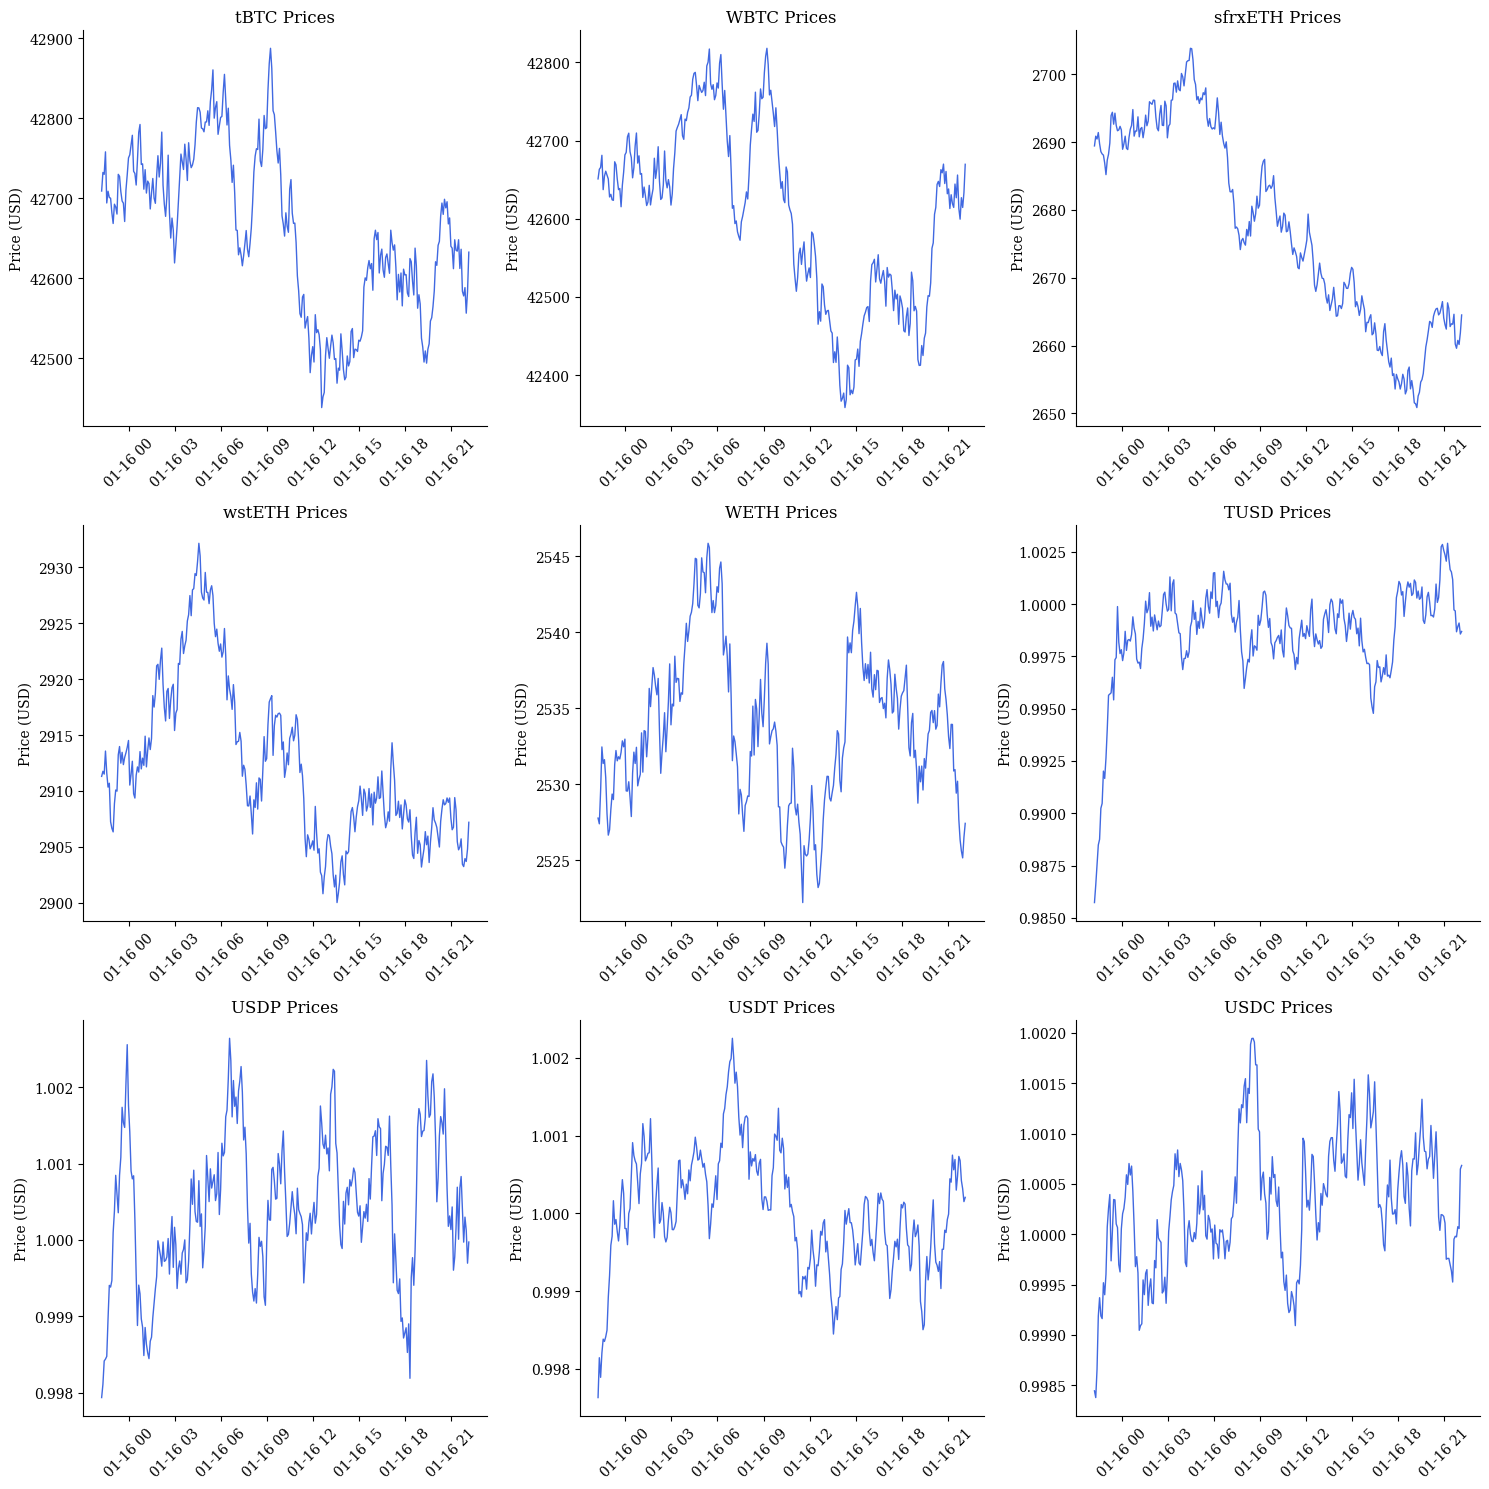

In [10]:
results.plot_prices()

In [11]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt,Bad Debt on Controller Wsteth,System Health,System Health on Controller Wsteth,Borrower Loss,Hard Liquidation Losses,Soft Liquidation Losses,Value Leakage,Keeper Profit,Keeper Count,Keeper Profit on Pk Crvusd/Tusd,Keeper Count on Pk Crvusd/Tusd,Keeper Profit on Pk Crvusd/Usdp,Keeper Count on Pk Crvusd/Usdp,Keeper Profit on Pk Crvusd/Usdc,Keeper Count on Pk Crvusd/Usdc,Keeper Profit on Pk Crvusd/Usdt,Keeper Count on Pk Crvusd/Usdt,Liquidator Profit,Liquidator Count,Liquidator Profit on Controller Wsteth,Liquidator Count on Controller Wsteth,Arbitrageur Profit,Arbitrageur Count,Aggregator Price,Stableswap Crvusd_Tusd Price,Stableswap Crvusd_Usdp Price,Stableswap Crvusd_Usdc Price,Stableswap Crvusd_Usdt Price,Debt Liquidated,Liquidation Count,Debt Liquidated on Controller Wsteth,Collateral Liquidated on Controller Wsteth,PK Debt,Pk Crvusd/Tusd Debt,Pk Crvusd/Usdp Debt,Pk Crvusd/Usdc Debt,Pk Crvusd/Usdt Debt,Total crvUSD Liquidity,Stableswap Crvusd_Tusd crvUSD Liquidity,Stableswap Crvusd_Usdp crvUSD Liquidity,Stableswap Crvusd_Usdc crvUSD Liquidity,Stableswap Crvusd_Usdt crvUSD Liquidity,Total Debt,Controller Wsteth Total Debt,Llamma Wsteth Price,Llamma Wsteth Oracle Price
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-16 21:48:16,0.0,0.0,1.059250,1.059250,385.480368,0.0,385.480368,5656.790082,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,5656.790082,206,0.999009,0.999107,0.998341,0.999053,0.99889,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,2.304303e+07,1.755478e+06,1.358353e+06,1.586956e+07,4.059634e+06,5.390832e+07,5.390832e+07,2889.413743,2901.966536
2024-01-16 21:53:16,0.0,0.0,1.060019,1.060019,385.480368,0.0,385.480368,5656.790082,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,5656.790082,206,0.998999,0.999107,0.998341,0.999053,0.99889,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,2.304303e+07,1.755478e+06,1.358353e+06,1.586956e+07,4.059634e+06,5.390832e+07,5.390832e+07,2892.552445,2903.024460
2024-01-16 21:58:16,0.0,0.0,1.060016,1.060016,385.480368,0.0,385.480368,5656.790082,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,5656.790082,206,0.998995,0.999107,0.998341,0.999053,0.99889,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,2.304303e+07,1.755478e+06,1.358353e+06,1.586956e+07,4.059634e+06,5.390832e+07,5.390832e+07,2892.544931,2903.025000
2024-01-16 22:03:16,0.0,0.0,1.060493,1.060493,385.480368,0.0,385.480368,5697.279662,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,5697.279662,209,0.998989,0.999576,0.998521,0.998983,0.99889,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,2.304302e+07,1.607567e+06,1.332654e+06,1.604316e+07,4.059634e+06,5.390832e+07,5.390832e+07,2894.498749,2903.684331
2024-01-16 22:08:16,0.0,0.0,1.062172,1.062172,385.480368,0.0,385.480368,5697.279662,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,5697.279662,209,0.998986,0.999576,0.998521,0.998983,0.99889,0.0,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,2.304302e+07,1.607567e+06,1.332654e+06,1.604316e+07,4.059634e+06,5.390832e+07,5.390832e+07,2901.365156,2905.991417


In [12]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6,
 'LiquidityMetric': 7,
 'MiscMetric': 8}

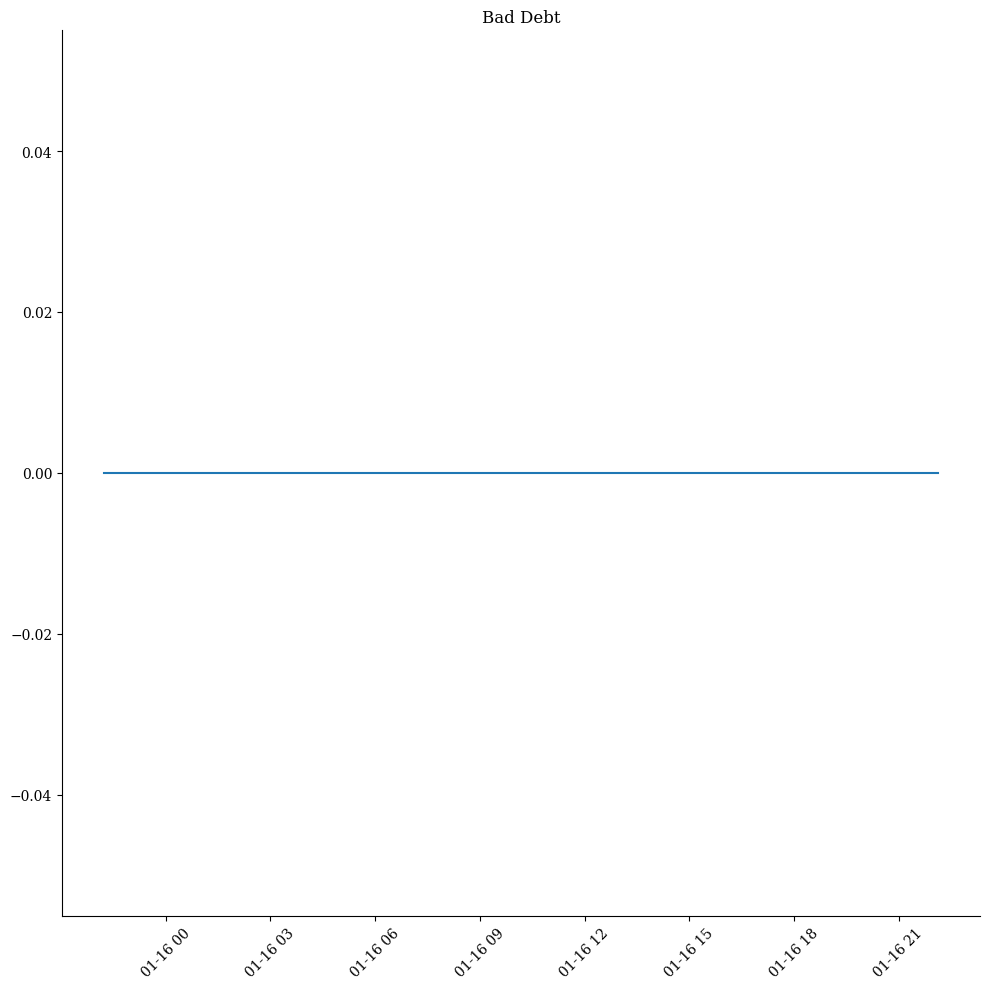

<Axes: title={'center': 'Bad Debt'}>

In [13]:
results.plot_metric(0, show=True)

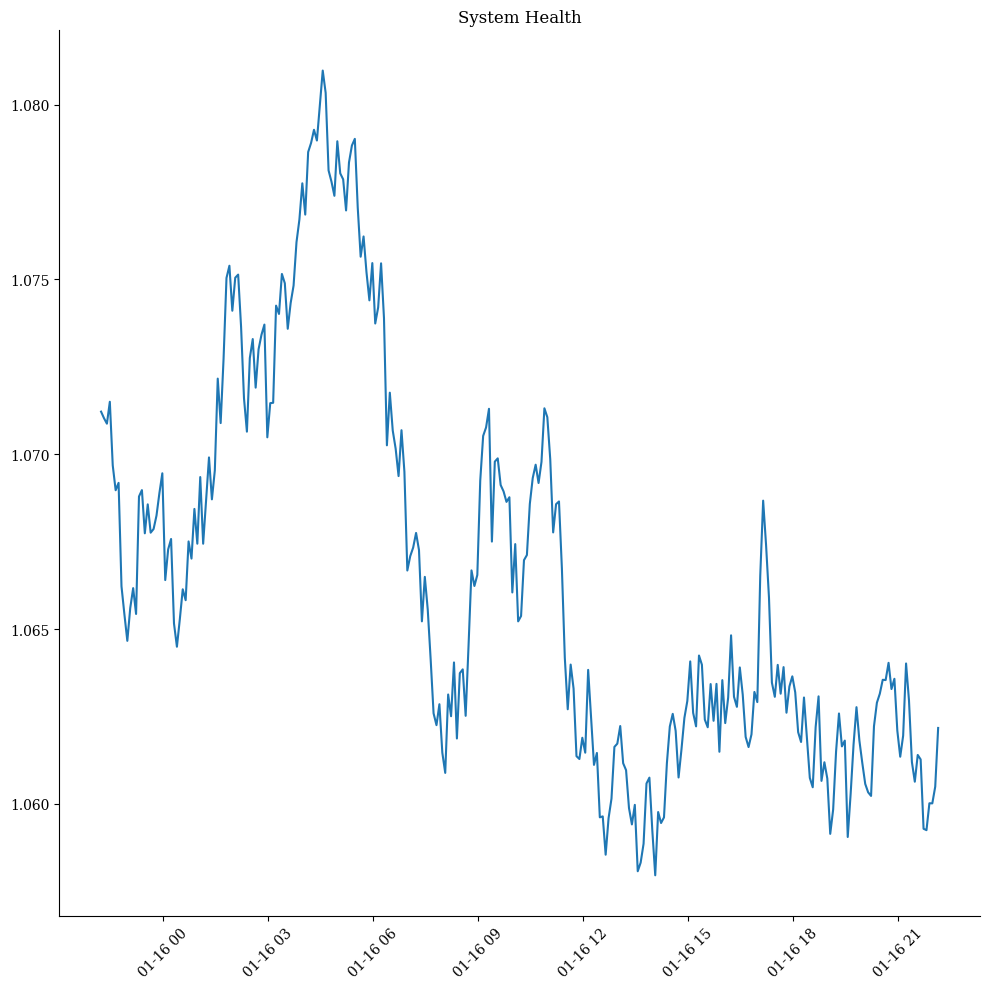

<Axes: title={'center': 'System Health'}>

In [14]:
results.plot_metric(1, show=True)

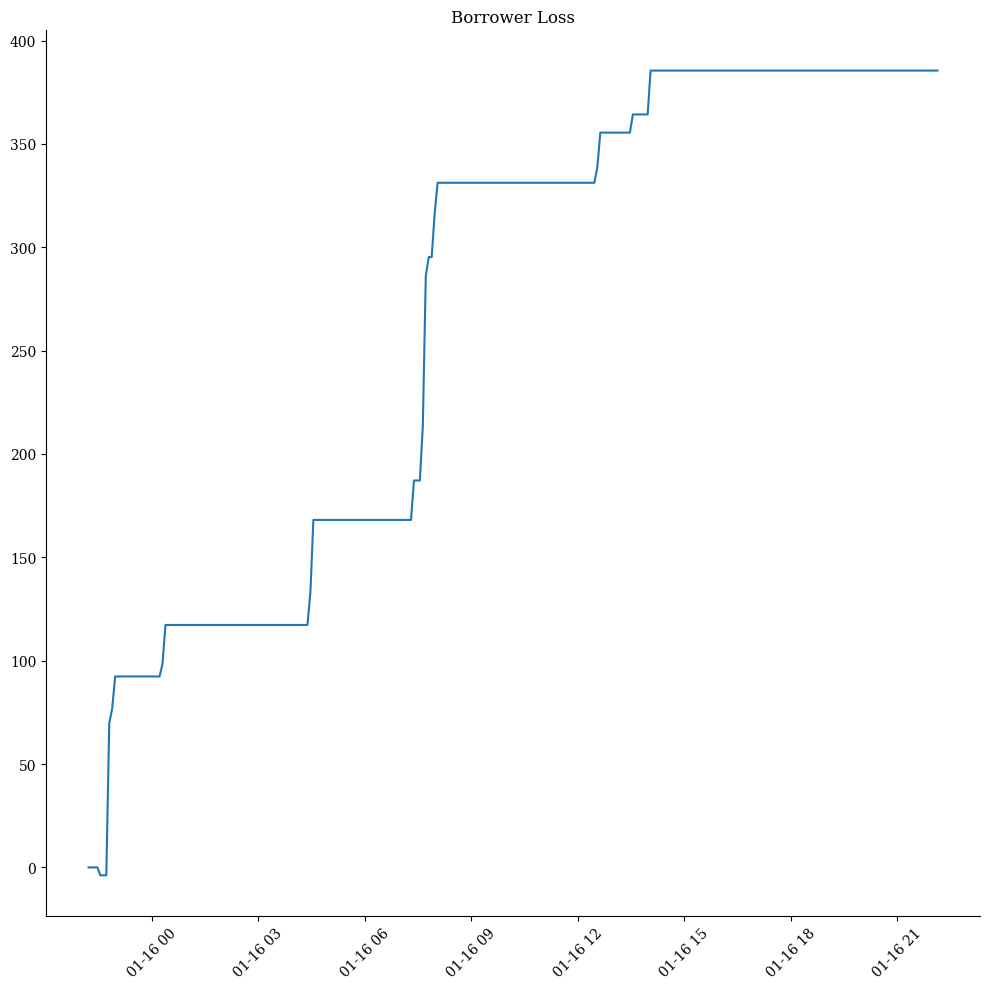

<Axes: title={'center': 'Borrower Loss'}>

In [15]:
results.plot_metric(2, show=True)

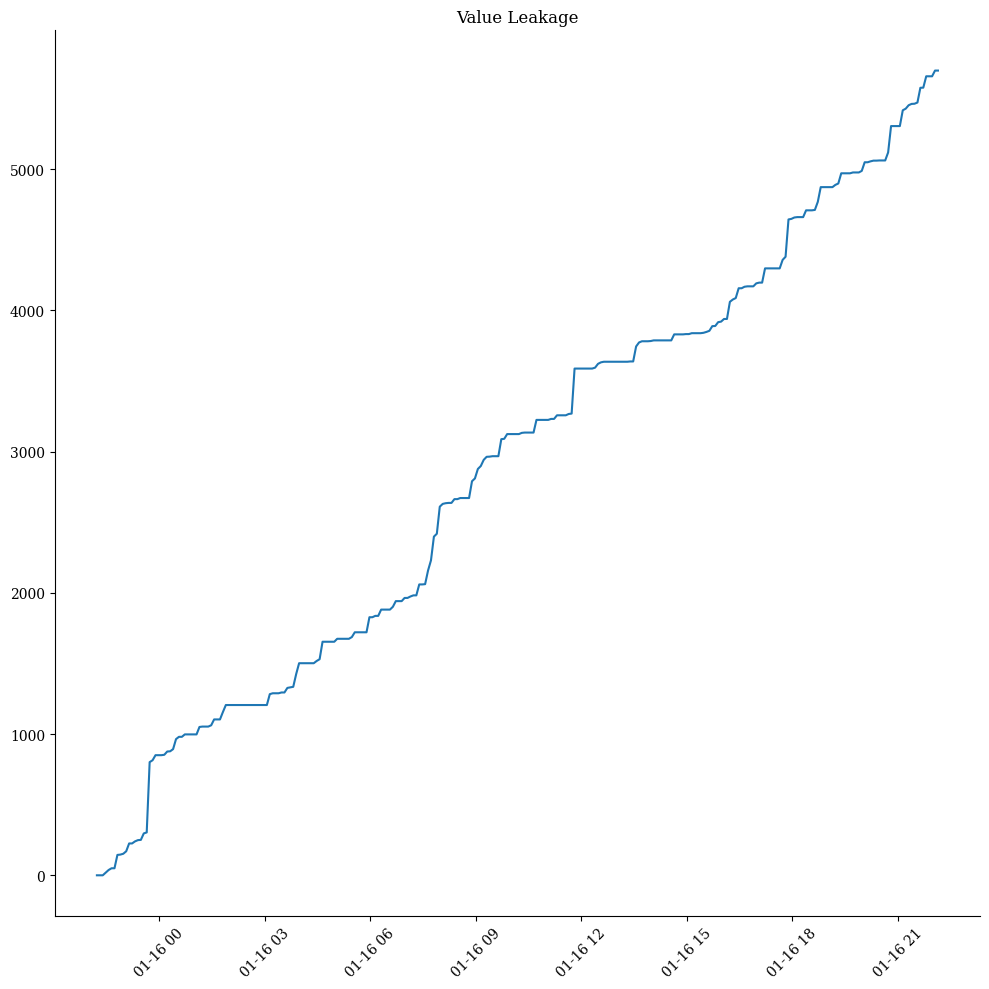

<Axes: title={'center': 'Value Leakage'}>

In [16]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

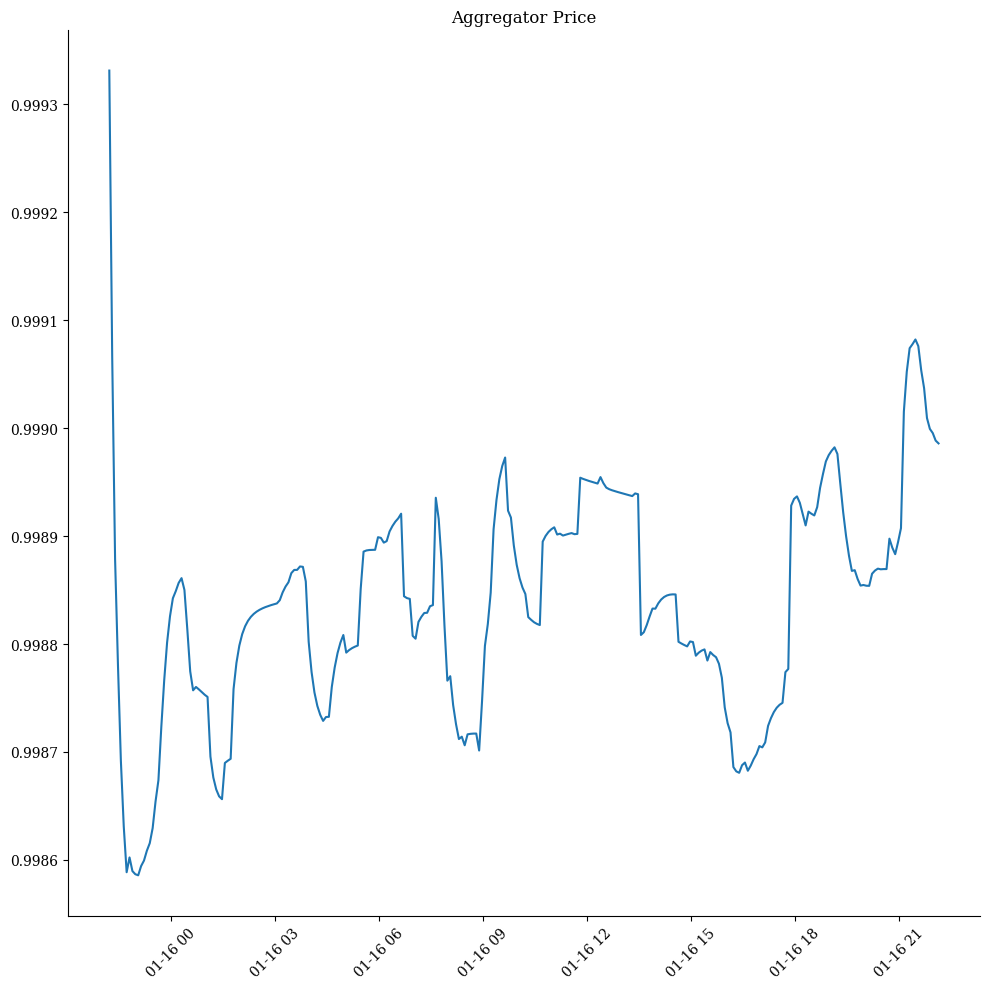

<Axes: title={'center': 'Aggregator Price'}>

In [17]:
results.plot_metric(4, show=True)

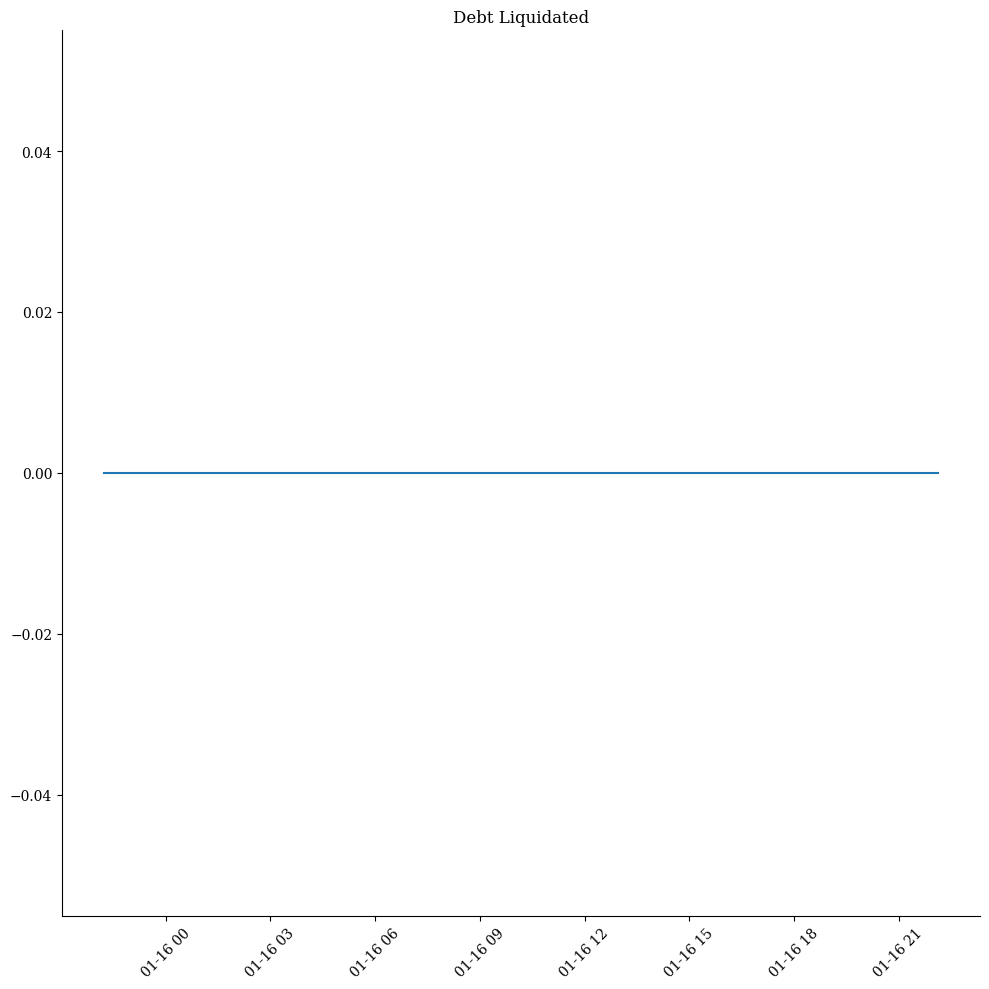

<Axes: title={'center': 'Debt Liquidated'}>

In [18]:
results.plot_metric(5, show=True)

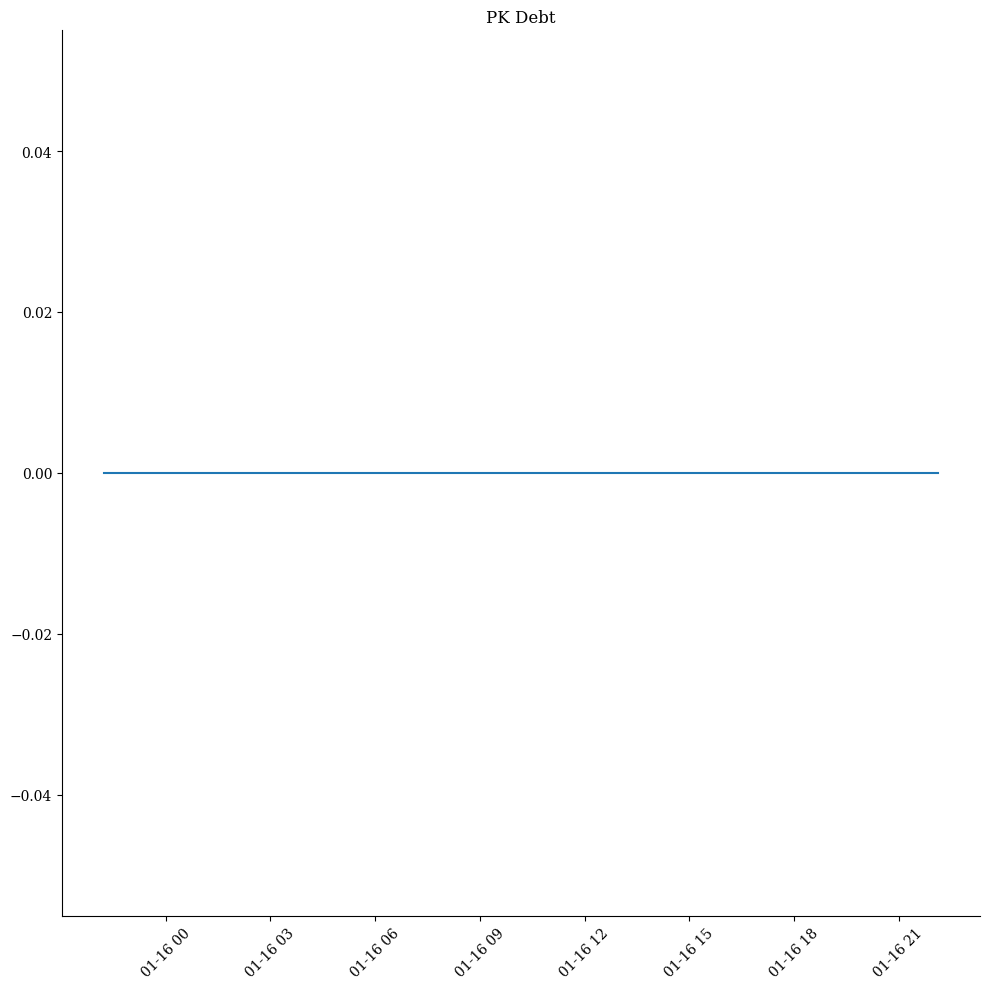

<Axes: title={'center': 'PK Debt'}>

In [19]:
results.plot_metric(6, show=True)

In [20]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
Bad Debt Max,0.000000e+00
Bad Debt Mean,0.000000e+00
Bad Debt On Controller Wsteth Max,0.000000e+00
Bad Debt On Controller Wsteth Mean,0.000000e+00
System Health Mean,1.066588e+00
...,...
Stableswap Crvusd_Usdt Crvusd Liquidity Min,3.074937e+06
Total Debt Mean,5.390832e+07
Controller Wsteth Total Debt Mean,5.390832e+07
Llamma Wsteth Price Mean,2.909841e+03


In [21]:
df.columns

Index(['Bad Debt', 'Bad Debt on Controller Wsteth', 'System Health',
       'System Health on Controller Wsteth', 'Borrower Loss',
       'Hard Liquidation Losses', 'Soft Liquidation Losses', 'Value Leakage',
       'Keeper Profit', 'Keeper Count', 'Keeper Profit on Pk Crvusd/Tusd',
       'Keeper Count on Pk Crvusd/Tusd', 'Keeper Profit on Pk Crvusd/Usdp',
       'Keeper Count on Pk Crvusd/Usdp', 'Keeper Profit on Pk Crvusd/Usdc',
       'Keeper Count on Pk Crvusd/Usdc', 'Keeper Profit on Pk Crvusd/Usdt',
       'Keeper Count on Pk Crvusd/Usdt', 'Liquidator Profit',
       'Liquidator Count', 'Liquidator Profit on Controller Wsteth',
       'Liquidator Count on Controller Wsteth', 'Arbitrageur Profit',
       'Arbitrageur Count', 'Aggregator Price', 'Stableswap Crvusd_Tusd Price',
       'Stableswap Crvusd_Usdp Price', 'Stableswap Crvusd_Usdc Price',
       'Stableswap Crvusd_Usdt Price', 'Debt Liquidated', 'Liquidation Count',
       'Debt Liquidated on Controller Wsteth',
       'Co